Learned Policy (Lab 8 - Prioritized Sweeping):
→ → → → ↓ ↓
→ ↑ ↑ X ↓ ↓
↑ ↑ █ → → ↓
↓ █ → ↑ X ↓
→ → ↑ ↑ █ ↓
→ ↑ ↑ ↑ → G


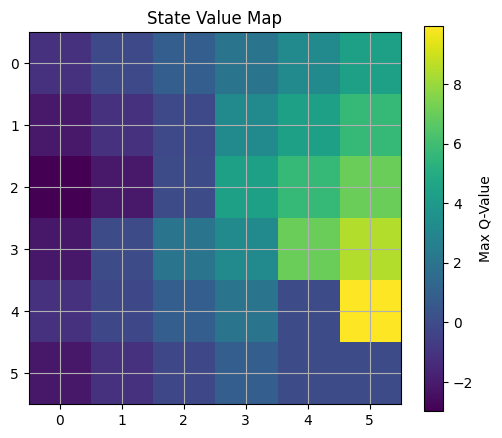

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict

# Environment setup
GRID_SIZE = 6
GOAL = (5, 5)
OBSTACLES = {(2, 2), (3, 1), (4, 4)}
TRAPS = {(1, 3), (3, 4)}
ACTIONS = ['U', 'D', 'L', 'R']
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

REWARD_GOAL = 10
REWARD_TRAP = -10
REWARD_STEP = -1

EPISODES = 100
MAX_STEPS = 50

ALPHA = 0.1
GAMMA = 0.95
EPSILON = 0.1
THETA = 0.01

Q = defaultdict(lambda: {a: 0 for a in ACTIONS})
model = {}
priority_queue = []

def is_valid(pos):
    return 0 <= pos[0] < GRID_SIZE and 0 <= pos[1] < GRID_SIZE and pos not in OBSTACLES

def step(state, action):
    dx, dy = ACTION_MAP[action]
    next_state = (state[0] + dx, state[1] + dy)
    if not is_valid(next_state):
        next_state = state
    if next_state == GOAL:
        return next_state, REWARD_GOAL
    if next_state in TRAPS:
        return next_state, REWARD_TRAP
    return next_state, REWARD_STEP

def select_action(state):
    if np.random.rand() < EPSILON:
        return np.random.choice(ACTIONS)
    return max(Q[state], key=Q[state].get)

def update_priority(state, action, reward, next_state):
    target = reward + GAMMA * max(Q[next_state].values())
    diff = abs(Q[state][action] - target)
    if diff > THETA:
        heapq.heappush(priority_queue, (-diff, state, action))

def update_q():
    for _ in range(50):
        if not priority_queue:
            break
        _, s, a = heapq.heappop(priority_queue)
        s_, r = model[(s, a)]
        target = r + GAMMA * max(Q[s_].values())
        Q[s][a] += ALPHA * (target - Q[s][a])
        # Update predecessors
        for a2 in ACTIONS:
            dx, dy = ACTION_MAP[a2]
            prev = (s[0] - dx, s[1] - dy)
            if is_valid(prev) and (prev, a2) in model:
                s_prev_, r_prev = model[(prev, a2)]
                update_priority(prev, a2, r_prev, s_prev_)

# Training loop
for ep in range(EPISODES):
    state = (0, 0)
    for _ in range(MAX_STEPS):
        action = select_action(state)
        next_state, reward = step(state, action)
        model[(state, action)] = (next_state, reward)
        update_priority(state, action, reward, next_state)
        update_q()
        if next_state == GOAL:
            break
        state = next_state

# Visualization with arrows
arrow_map = {'U': '↑', 'D': '↓', 'L': '←', 'R': '→'}
policy_grid = np.full((GRID_SIZE, GRID_SIZE), ' ', dtype='<U2')
value_grid = np.zeros((GRID_SIZE, GRID_SIZE))

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        cell = (i, j)
        if cell == GOAL:
            policy_grid[i, j] = 'G'
        elif cell in OBSTACLES:
            policy_grid[i, j] = '█'
        elif cell in TRAPS:
            policy_grid[i, j] = 'X'
        else:
            best_a = max(Q[cell], key=Q[cell].get)
            policy_grid[i, j] = arrow_map[best_a]
        value_grid[i, j] = max(Q[cell].values())

# Display learned policy
print("Learned Policy (Lab 8 - Prioritized Sweeping):")
for row in policy_grid:
    print(' '.join(row))

# Plot value grid
plt.figure(figsize=(6, 5))
plt.imshow(value_grid, cmap='viridis')
plt.colorbar(label="Max Q-Value")
plt.title("State Value Map")
plt.xticks(np.arange(GRID_SIZE))
plt.yticks(np.arange(GRID_SIZE))
plt.grid(True)
plt.show()


TASK 1: Survivors randomly change locations every few episodes.

We’ll move the GOAL location every, say, 10 episodes.

The robot will keep the learned Q-values and model but update priorities accordingly.

TASK 2: Certain cells can probabilistically turn into traps mid-episode.

Add a set of unstable cells with a probability of turning into traps during the episode.

When a cell turns into a trap, robot reprioritizes states leading to that cell.

TASK 3: Multiple robots learn independently but share knowledge of dangerous zones.

Simulate multiple agents starting at different positions.

They share the global trap map and update dangerous zones together.

Episode 10: Survivor moved to (4, 1)
Episode 20: Survivor moved to (3, 3)
Episode 30: Survivor moved to (3, 2)
Episode 40: Survivor moved to (3, 2)
Episode 50: Survivor moved to (4, 1)
Episode 60: Survivor moved to (4, 2)
Episode 70: Survivor moved to (1, 5)
Episode 80: Survivor moved to (5, 5)
Episode 90: Survivor moved to (5, 1)
Final Learned Policy for Robot 0 with Survivor at (5, 1) and Traps {(2, 3), (1, 2), (3, 4), (4, 3), (1, 3)}:
↓ ↓ ← ← ← ↓
↓ ← X X ↑ ←
↓ ← █ X ↑ ↑
↓ █ ↓ ← X ↑
→ ↓ ← X █ ↑
→ G ↑ ↑ ↑ ↑


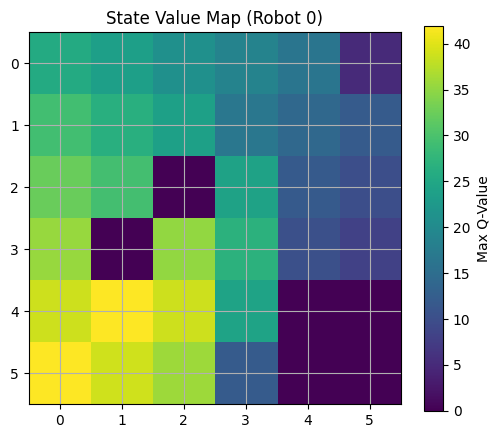

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict

# Environment setup
GRID_SIZE = 6

# Initial survivor location (will change every 10 episodes)
GOAL = (5, 5)

OBSTACLES = {(2, 2), (3, 1), (4, 4)}

# Initial traps, but traps can appear dynamically during episode
INITIAL_TRAPS = {(1, 3), (3, 4)}

# Unstable cells that can turn into traps mid-episode with some probability
UNSTABLE_CELLS = {(1, 2), (2, 3), (4, 3)}
PROB_TRAP_APPEAR = 0.3  # 30% chance per step to become trap

ACTIONS = ['U', 'D', 'L', 'R']
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

REWARD_GOAL = 10
REWARD_TRAP = -10
REWARD_STEP = -1
REWARD_OVERLAP = -5  # Penalty for overlapping paths between robots

EPISODES = 100
MAX_STEPS = 50
SURVIVOR_MOVE_INTERVAL = 10  # Episodes after which survivor moves

ALPHA = 0.1
GAMMA = 0.95
EPSILON = 0.1
THETA = 0.01

NUM_ROBOTS = 3

# Q-values and models for each robot
Qs = [defaultdict(lambda: {a: 0 for a in ACTIONS}) for _ in range(NUM_ROBOTS)]
models = [{} for _ in range(NUM_ROBOTS)]
priority_queues = [[] for _ in range(NUM_ROBOTS)]

# Shared traps that can update dynamically
traps = set(INITIAL_TRAPS)

# Starting positions for robots - spread out for better coverage
START_POSITIONS = [(0,0), (0,5), (5,0)]

def is_valid(pos):
    return 0 <= pos[0] < GRID_SIZE and 0 <= pos[1] < GRID_SIZE and pos not in OBSTACLES

def step(state, action, current_traps):
    dx, dy = ACTION_MAP[action]
    next_state = (state[0] + dx, state[1] + dy)
    if not is_valid(next_state):
        next_state = state
    if next_state == GOAL:
        return next_state, REWARD_GOAL
    if next_state in current_traps:
        return next_state, REWARD_TRAP
    return next_state, REWARD_STEP

def select_action(state, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(ACTIONS)
    return max(Q[state], key=Q[state].get)

def update_priority(state, action, reward, next_state, Q, priority_queue):
    target = reward + GAMMA * max(Q[next_state].values())
    diff = abs(Q[state][action] - target)
    if diff > THETA:
        heapq.heappush(priority_queue, (-diff, state, action))

def update_q(Q, model, priority_queue):
    for _ in range(50):
        if not priority_queue:
            break
        _, s, a = heapq.heappop(priority_queue)
        s_, r = model[(s, a)]
        target = r + GAMMA * max(Q[s_].values())
        Q[s][a] += ALPHA * (target - Q[s][a])
        # Update predecessors
        for a2 in ACTIONS:
            dx, dy = ACTION_MAP[a2]
            prev = (s[0] - dx, s[1] - dy)
            if is_valid(prev) and (prev, a2) in model:
                s_prev_, r_prev = model[(prev, a2)]
                # Recursively update priority
                new_target = r_prev + GAMMA * max(Q[s_prev_].values())
                diff = abs(Q[prev][a2] - new_target)
                if diff > THETA:
                    heapq.heappush(priority_queue, (-diff, prev, a2))

def move_survivor():
    """Randomly move survivor to a new valid location"""
    while True:
        new_goal = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
        if new_goal not in OBSTACLES and new_goal not in traps:
            return new_goal

def dynamic_trap_update(current_traps):
    """Update traps probabilistically by turning unstable cells into traps"""
    new_traps = set(current_traps)
    for cell in UNSTABLE_CELLS:
        if cell not in current_traps:
            if np.random.rand() < PROB_TRAP_APPEAR:
                new_traps.add(cell)
    return new_traps

def penalty_overlap(states_list):
    """Return a penalty if multiple robots occupy same cell"""
    penalty = 0
    seen = set()
    for s in states_list:
        if s in seen:
            penalty += REWARD_OVERLAP
        else:
            seen.add(s)
    return penalty

# Training loop for multiple robots
for ep in range(EPISODES):
    # Move survivor every SURVIVOR_MOVE_INTERVAL episodes
    if ep > 0 and ep % SURVIVOR_MOVE_INTERVAL == 0:
        GOAL = move_survivor()
        print(f"Episode {ep}: Survivor moved to {GOAL}")

    # Reset traps to initial traps at the start of episode
    traps = set(INITIAL_TRAPS)

    # Initialize states for all robots
    states = list(START_POSITIONS)

    for step_idx in range(MAX_STEPS):
        # Update traps dynamically each step
        traps = dynamic_trap_update(traps)

        # Robots take actions
        next_states = []
        rewards = []
        for i in range(NUM_ROBOTS):
            Q = Qs[i]
            model = models[i]
            priority_queue = priority_queues[i]
            state = states[i]
            action = select_action(state, Q, EPSILON)
            next_state, reward = step(state, action, traps)
            # Include penalty for overlapping positions with other robots
            future_positions = [ns for idx, ns in enumerate(states) if idx != i]
            if next_state in future_positions:
                reward += REWARD_OVERLAP

            model[(state, action)] = (next_state, reward)
            update_priority(state, action, reward, next_state, Q, priority_queue)
            update_q(Q, model, priority_queue)
            next_states.append(next_state)
            rewards.append(reward)

        states = next_states

        # If all robots reach goal, break early
        if all(s == GOAL for s in states):
            break

# Visualization for one robot's learned policy (robot 0)
Q = Qs[0]

arrow_map = {'U': '↑', 'D': '↓', 'L': '←', 'R': '→'}
policy_grid = np.full((GRID_SIZE, GRID_SIZE), ' ', dtype='<U2')
value_grid = np.zeros((GRID_SIZE, GRID_SIZE))

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        cell = (i, j)
        if cell == GOAL:
            policy_grid[i, j] = 'G'
        elif cell in OBSTACLES:
            policy_grid[i, j] = '█'
        elif cell in traps:
            policy_grid[i, j] = 'X'
        else:
            best_a = max(Q[cell], key=Q[cell].get)
            policy_grid[i, j] = arrow_map[best_a]
        value_grid[i, j] = max(Q[cell].values())

print(f"Final Learned Policy for Robot 0 with Survivor at {GOAL} and Traps {traps}:")
for row in policy_grid:
    print(' '.join(row))

# Plot value grid for robot 0
plt.figure(figsize=(6, 5))
plt.imshow(value_grid, cmap='viridis')
plt.colorbar(label="Max Q-Value")
plt.title("State Value Map (Robot 0)")
plt.xticks(np.arange(GRID_SIZE))
plt.yticks(np.arange(GRID_SIZE))
plt.grid(True)
plt.show()
